In [1]:
# Impoting required packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import matplotlib.lines as mlines

# setting default option
pd.set_option("mode.copy_on_write", True)
warnings.simplefilter(action="ignore", category=FutureWarning)

In [2]:
# loading the Dataset
mortality = pd.read_parquet("../../01_Data/02_Processed/03_Mortality_Final.parquet")

In [3]:
mortality.sample(5)

,State,State_Code,County,County_Code,Year,Deaths,Population,Mortality_Rate
8586,Oklahoma,OK,POTTAWATOMIE,40125,2004,8,67072.0,0.000119
5004,Michigan,MI,MONROE,26115,2014,35,149919.0,0.000233
5755,Missouri,MO,LINCOLN,29113,2008,6,51847.0,0.000116
9861,Tennessee,TN,CUMBERLAND,47035,2005,5,51758.0,0.000097
2609,Hawaii,HI,HONOLULU,15003,2007,75,925335.0,0.000081


In [4]:
# Mortality Multiplier
mort_mul = 100000
mortality["Mortality_mul"] = mortality["Mortality_Rate"] * mort_mul

# Global Setting for ylabels so that they are consistent across all plots
ylabels = f"Mortality per {mort_mul:,} Population"

In [5]:
# Subset the dataset for the analysis
def prepare_data(
    dataset, test_state, control_states, policy_year, start_year, end_year
):
    # Filter states
    state_list = [test_state] + control_states
    sub_dataset = dataset[dataset["State_Code"].isin(state_list)]

    # Filter years
    sub_dataset = sub_dataset[
        (sub_dataset["Year"] >= start_year) & (sub_dataset["Year"] <= end_year)
    ]

    # Tagging for pre-post policy implementation and test-control
    sub_dataset["policy_implementation"] = sub_dataset["Year"] >= policy_year
    sub_dataset["State_Type"] = sub_dataset["State_Code"].apply(
        lambda x: "Test" if x == test_state else "Control"
    )

    return sub_dataset

In [6]:
def plot_pre_post_policy_graph(dataset_in, test_state, policy_year, metric_column):
    fig, ax = plt.subplots(1, 1, figsize=(10, 5))

    # Convert YEAR and metric_column to float64
    dataset = dataset_in.copy()  # Copy to avoid changing the original dataframe
    # dataset["YEAR"] = dataset["YEAR"].astype("float64")
    # dataset[metric_column] = dataset[metric_column].astype("float64")

    sns.regplot(
        data=dataset[
            (dataset["State_Code"] == test_state)
            & (dataset["policy_implementation"] == True)
        ],
        x="Year",
        y=metric_column,
        line_kws={"color": "red"},
        ax=ax,
        scatter=False,
    )

    sns.regplot(
        data=dataset[
            (dataset["State_Code"] == test_state)
            & (dataset["policy_implementation"] != True)
        ],
        x="Year",
        y=metric_column,
        line_kws={"color": "blue"},
        ax=ax,
        scatter=False,
    )

    ax.axvline(policy_year, ls="--", color="orange")

    plt.legend(
        handles=[
            mlines.Line2D([], [], color="blue", label="Pre-Policy"),
            mlines.Line2D([], [], color="red", label="Post-Policy"),
        ],
        loc="lower right",
    )

    plt.title(f"Pre-Post Policy Implementation Trend for Mortality: {test_state}")
    plt.ylabel(ylabels)

    plt.show()

In [7]:
def plot_diff_in_diff_graph(dataset_in, test_state, policy_year, metric_column):
    fig, ax = plt.subplots(1, 1, figsize=(10, 5))

    # Convert YEAR and metric_column to float64
    dataset = dataset_in.copy()  # Copy to avoid changing the original dataframe
    # dataset["YEAR"] = dataset["YEAR"].astype("float64")
    # dataset[metric_column] = dataset[metric_column].astype("float64")

    # Plotting for test state - pre-policy
    sns.regplot(
        data=dataset[
            (dataset["State_Type"] == "Test")
            & (dataset["policy_implementation"] != True)
        ],
        x="Year",
        y=metric_column,
        line_kws={"color": "blue"},
        ax=ax,
        scatter=False,
    )

    # Plotting for test state - post-policy
    sns.regplot(
        data=dataset[
            (dataset["State_Type"] == "Test")
            & (dataset["policy_implementation"] == True)
        ],
        x="Year",
        y=metric_column,
        line_kws={"color": "blue"},
        ax=ax,
        scatter=False,
    )

    # Plotting for control states - pre-policy
    sns.regplot(
        data=dataset[
            (dataset["State_Type"] == "Control")
            & (dataset["policy_implementation"] != True)
        ],
        x="Year",
        y=metric_column,
        line_kws={"color": "red"},
        ax=ax,
        scatter=False,
    )

    # Plotting for control states - post-policy
    sns.regplot(
        data=dataset[
            (dataset["State_Type"] == "Control")
            & (dataset["policy_implementation"] == True)
        ],
        x="Year",
        y=metric_column,
        line_kws={"color": "red"},
        ax=ax,
        scatter=False,
    )

    # Adding vertical line for policy year
    ax.axvline(policy_year, ls="--", color="orange")

    # Creating custom legend handles
    blue_line = mlines.Line2D([], [], color="blue", label="Test State")
    red_line = mlines.Line2D([], [], color="red", label="Control States")

    # Adding legends
    plt.legend(handles=[blue_line, red_line], loc="lower right")
    plt.title(f"Difference-in-Difference Analysis for Mortality: {test_state}")
    plt.ylabel(ylabels)

    plt.show()

In [8]:
def plot_all_states(dataset_in, test_state, policy_year, metric_column):
    # Convert YEAR and metric_column to float64
    dataset = dataset_in.copy()  # Copy to avoid changing the original dataframe
    # dataset["YEAR"] = dataset["YEAR"].astype("float64")
    # dataset[metric_column] = dataset[metric_column].astype("float64")

    plot = sns.lmplot(
        data=dataset,
        x="Year",
        y=metric_column,
        hue="policy_implementation",
        legend=False,
        row="State_Code",
    )

    # Set titles for each subplot
    plot = plot.set_titles("{row_name}")

    plt.legend(
        loc="lower right",
        # bbox_to_anchor=(0.5, -0.15),
        title="Policy Implementation",
        ncol=2,
    )

    ax = plot.axes[0, 0]

    ax.axvline(policy_year, ls="--", color="red")
    ax.set_ylabel(ylabels)
    plt.show()

# Washington

In [9]:
# Creating control variables

# Enter the Test State Below
test_state = "WA"

# Enter list of states required below, Included the test state
control_states = ["OR", "WI", "NJ"]

# Year control variable
policy_year = 2012  # year the policy was implemented
start_year = 2008  # desired start year for analysis
end_year = 2015  # desired end year for analysis

In [10]:
mortality_plot = prepare_data(
    mortality, test_state, control_states, policy_year, start_year, end_year
)
mortality_plot.sample(5)

,State,State_Code,County,County_Code,Year,Deaths,Population,Mortality_Rate,Mortality_mul,policy_implementation,State_Type
6151,New Jersey,NJ,CAMDEN,34007,2009,62,513668.0,0.000121,12.070053,False,Control
12073,Wisconsin,WI,JEFFERSON,55055,2014,13,84370.0,0.000154,15.408320,True,Control
11993,Wisconsin,WI,COLUMBIA,55021,2011,7,56712.0,0.000123,12.343067,False,Control
8846,Oregon,OR,YAMHILL,41071,2008,8,97537.0,0.000082,8.202016,False,Control
11618,Washington,WA,FRANKLIN,53021,2010,8,79076.0,0.000101,10.116850,False,Test


/Users/revanth/miniconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


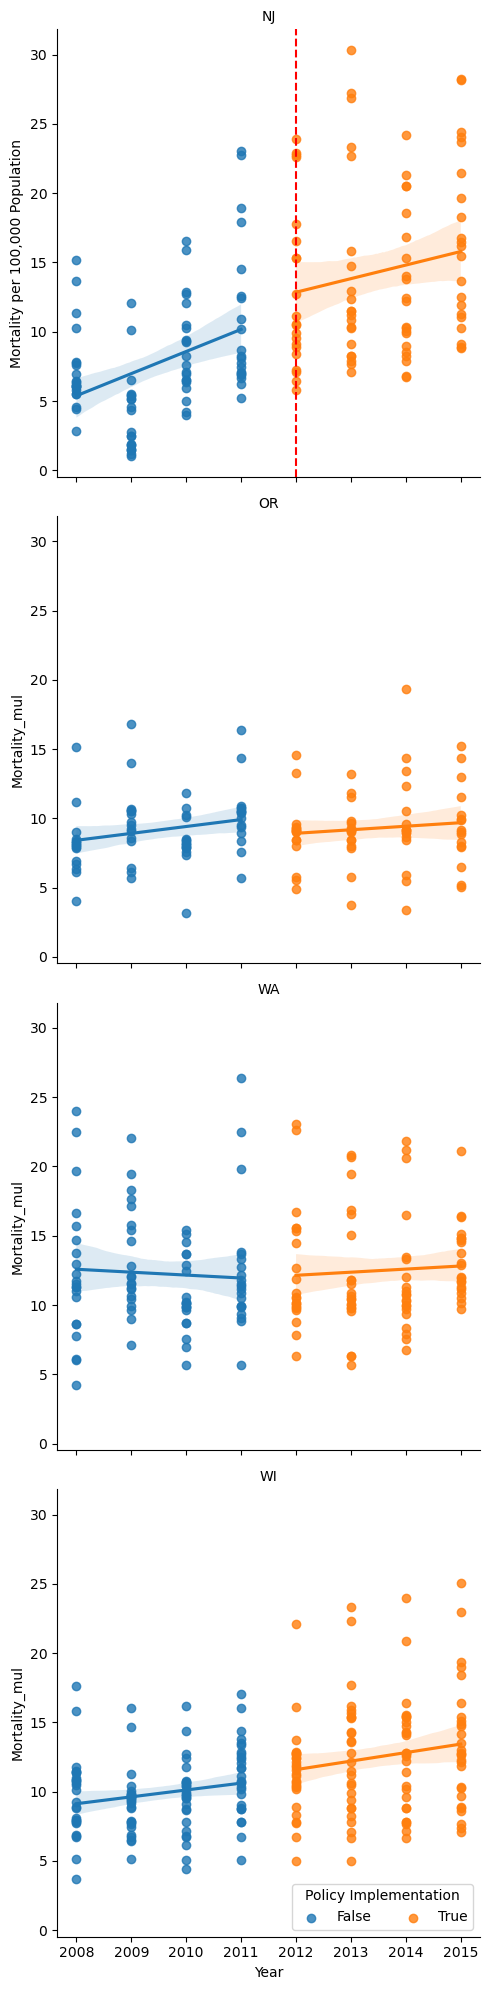

In [11]:
plot_all_states(mortality_plot, test_state, policy_year, "Mortality_mul")

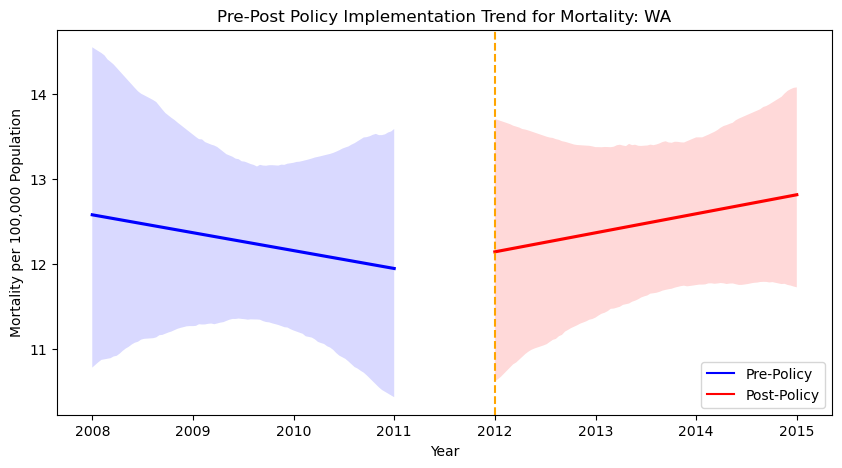

In [12]:
plot_pre_post_policy_graph(mortality_plot, test_state, policy_year, "Mortality_mul")

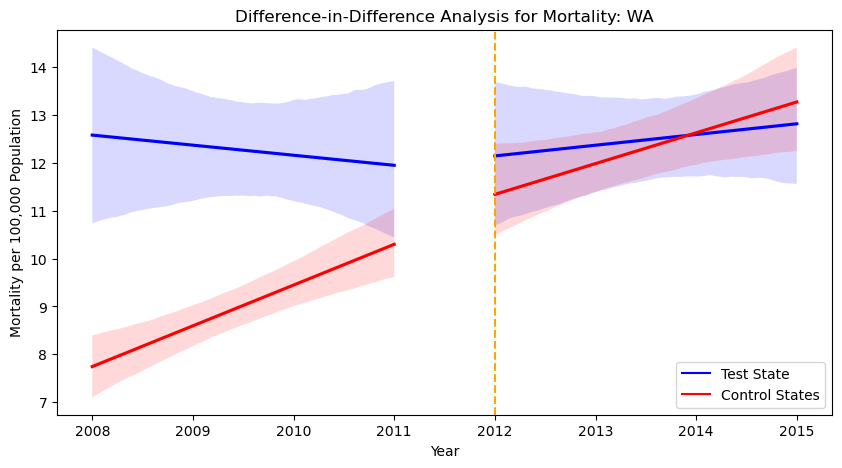

In [13]:
plot_diff_in_diff_graph(mortality_plot, test_state, policy_year, "Mortality_mul")

# Florida

In [14]:
# Creating control variables

# Enter the Test State Below
test_state = "FL"

# Enter list of states required below, Included the test state
control_states = ["GA", "NC", "LA"]

# Year control variable
policy_year = 2010  # year the policy was implemented
start_year = 2007  # desired start year for analysis
end_year = 2013  # desired end year for analysis

In [15]:
mortality_plot = prepare_data(
    mortality, test_state, control_states, policy_year, start_year, end_year
)
mortality_plot.sample(5)

,State,State_Code,County,County_Code,Year,Deaths,Population,Mortality_Rate,Mortality_mul,policy_implementation,State_Type
2193,Georgia,GA,CLARKE,13059,2011,13,118229.0,0.000110,10.995610,True,Control
1706,Florida,FL,HERNANDO,12053,2011,33,172877.0,0.000191,19.088716,True,Test
7750,North Carolina,NC,SURRY,37171,2010,16,73779.0,0.000217,21.686388,True,Control
4076,Louisiana,LA,LIVINGSTON,22063,2012,24,131521.0,0.000182,18.248036,True,Control
4010,Louisiana,LA,EAST BATON ROUGE,22033,2011,24,441627.0,0.000054,5.434450,True,Control


/Users/revanth/miniconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


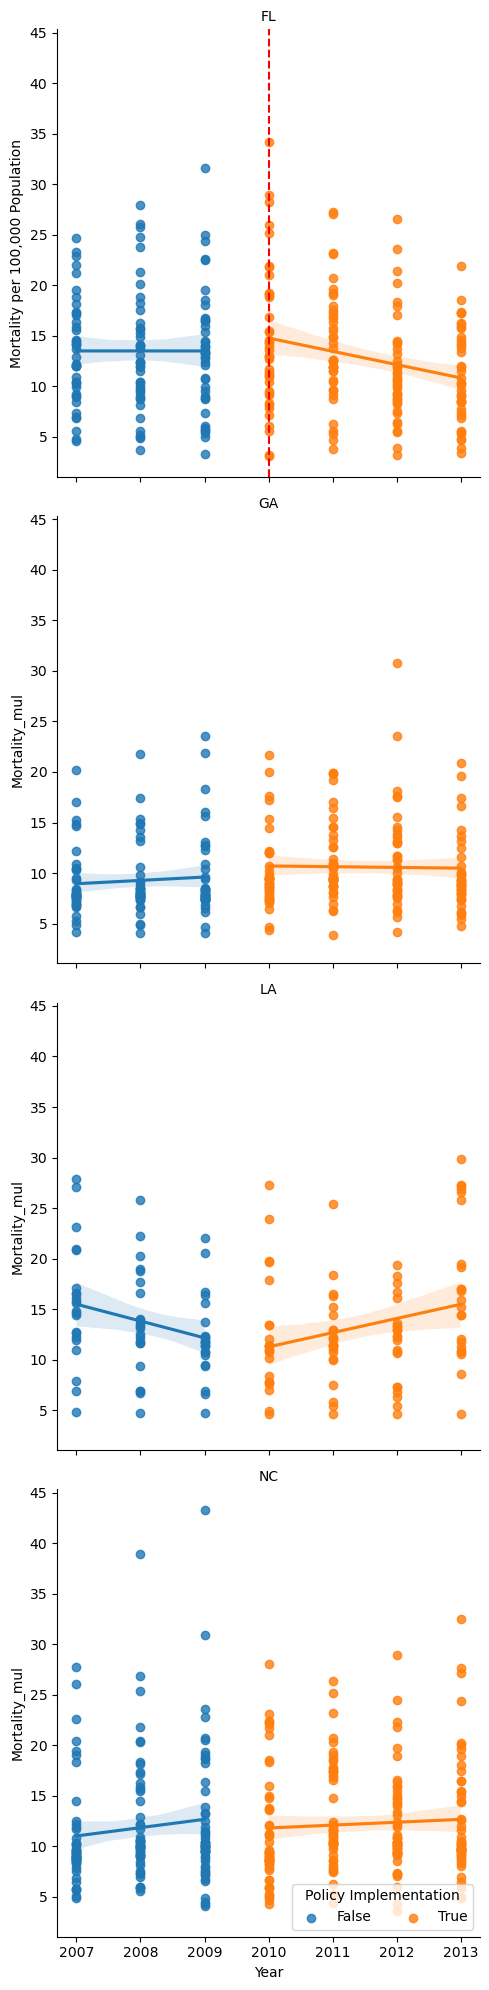

In [16]:
plot_all_states(mortality_plot, test_state, policy_year, "Mortality_mul")

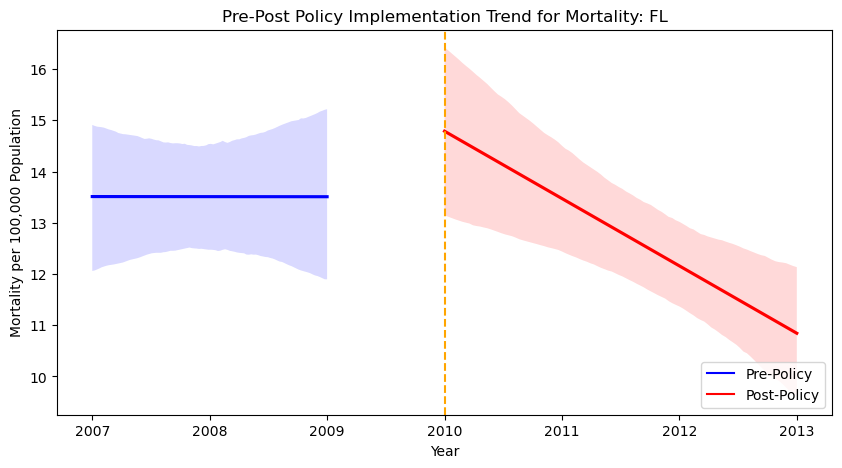

In [17]:
plot_pre_post_policy_graph(mortality_plot, test_state, policy_year, "Mortality_mul")

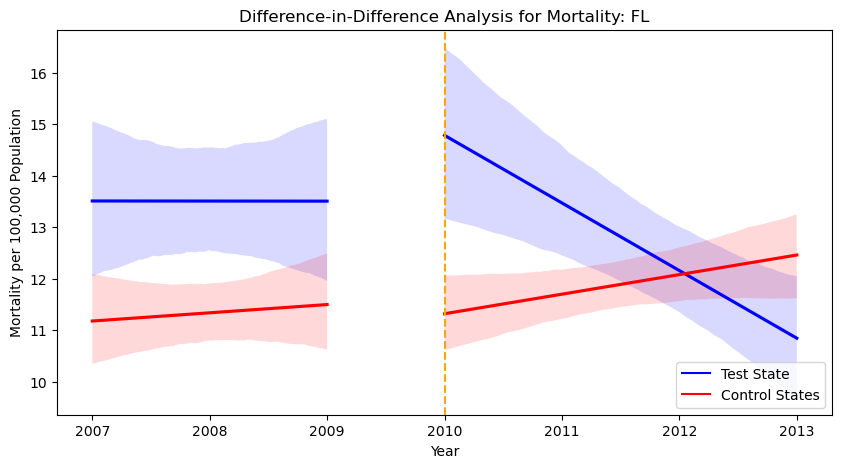

In [18]:
plot_diff_in_diff_graph(mortality_plot, test_state, policy_year, "Mortality_mul")

# Texas

In [19]:
# Creating control variables

# Enter the Test State Below
test_state = "TX"

# Enter list of states required below, Included the test state
control_states = ["LA", "AR", "OK", "MS", "AL", "AZ", "NM"]

# Year control variable
policy_year = 2007  # year the policy was implemented
start_year = 2003  # desired start year for analysis
end_year = 2011  # desired end year for analysis

In [20]:
mortality_plot = prepare_data(
    mortality, test_state, control_states, policy_year, start_year, end_year
)
mortality_plot.sample(5)

,State,State_Code,County,County_Code,Year,Deaths,Population,Mortality_Rate,Mortality_mul,policy_implementation,State_Type
10367,Texas,TX,ECTOR,48135,2007,21,130459.0,0.000161,16.097011,True,Test
3954,Louisiana,LA,ASCENSION,22005,2007,11,100132.0,0.000110,10.985499,True,Control
10520,Texas,TX,HENDERSON,48213,2005,5,78001.0,0.000064,6.410174,False,Test
10448,Texas,TX,GREGG,48183,2010,9,122044.0,0.000074,7.374390,True,Test
10178,Texas,TX,ANDERSON,48001,2007,4,57870.0,0.000069,6.912044,True,Test


/Users/revanth/miniconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


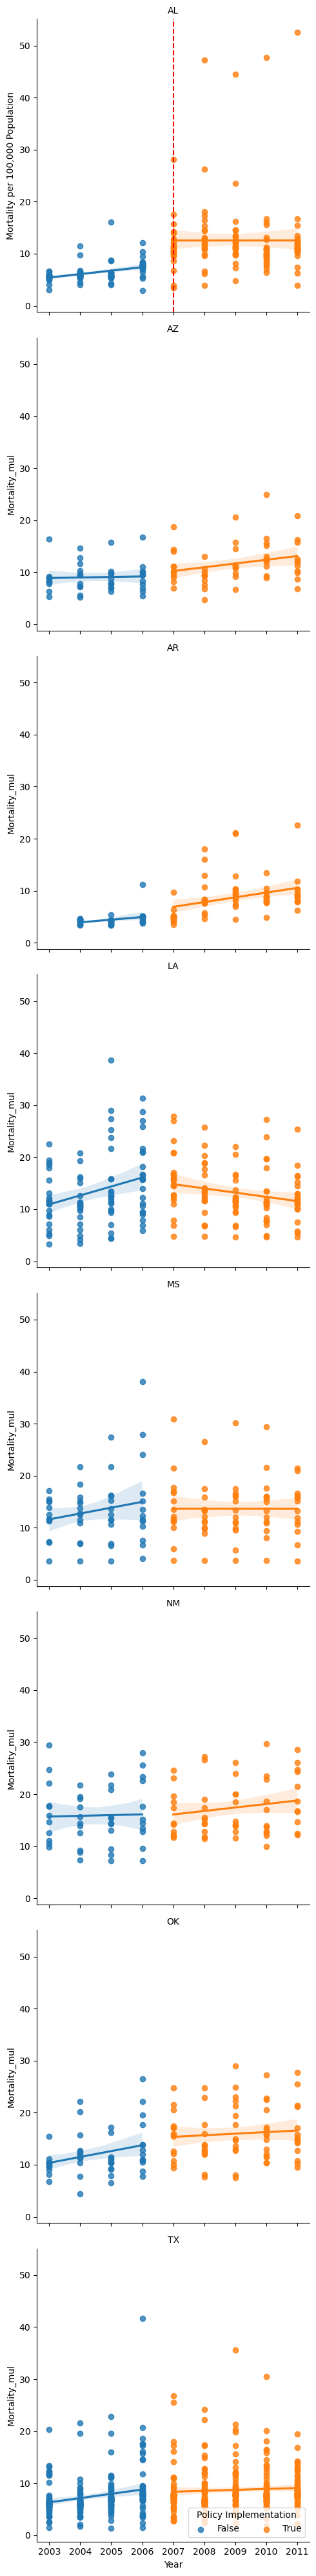

In [21]:
plot_all_states(mortality_plot, test_state, policy_year, "Mortality_mul")

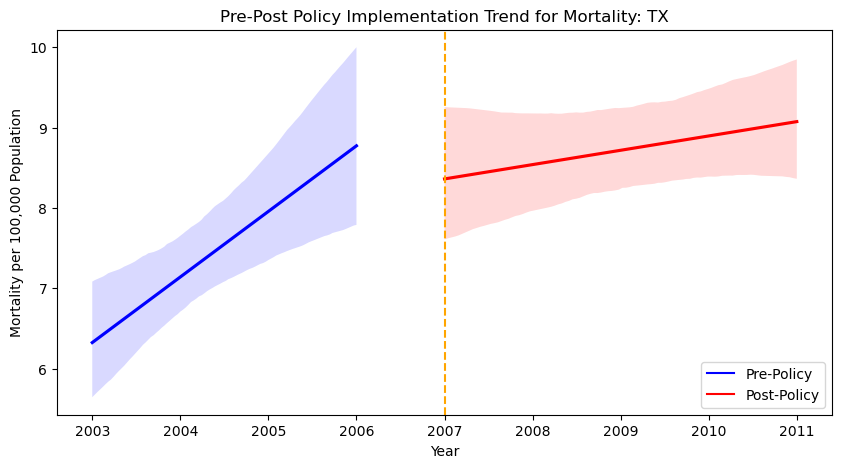

In [22]:
plot_pre_post_policy_graph(mortality_plot, test_state, policy_year, "Mortality_mul")

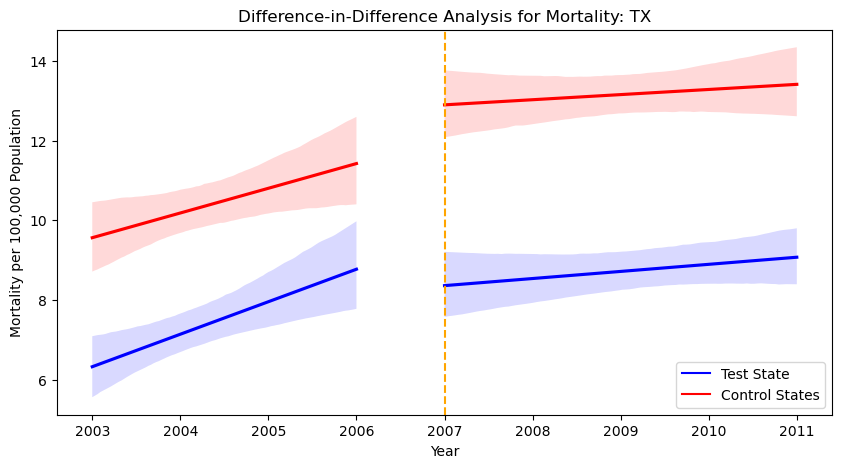

In [23]:
plot_diff_in_diff_graph(mortality_plot, test_state, policy_year, "Mortality_mul")